In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
from img_utils import *

2024-03-14 10:30:40.168642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 10:30:40.168695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 10:30:40.169849: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 10:30:40.175412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 10:30:41.083612: W tensorflow/compiler/tf2

# Loading Data 

In [3]:
path = "../nybolig-scrape/output"
houses_df = data_to_DF(path, max_houses=1000)
print("Number of datapoints of type 'Ejerlejlighed': ", len(houses_df))
display(houses_df)

[ WARN:0@2.786] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2.789] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2.793] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2.878] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@3.240] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@3.243] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@3.457] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@3.460] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@3.479] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check fil

Number of datapoints of type 'Ejerlejlighed':  735


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan
0,Acaciavej 1 1. 1867 Frederiksberg C,1867,ejerlejlighed,9995000,124,None,4.0,1875.0,2022.0,B,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,Agerskovvej 4D 2. 2610 Rødovre,2610,ejerlejlighed,1995000,70,None,2.0,1968.0,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,Agerskovvej 4M st. 2610 Rødovre,2610,ejerlejlighed,2195000,70,None,2.0,1968.0,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,Aggersborggade 9 1. tv 2100 København Ø,2100,ejerlejlighed,5650000,80,None,3.0,1896.0,1933.0,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,Aggersvoldvej 3B 3. 2700 Brønshøj,2700,ejerlejlighed,2725000,66,None,3.0,1934.0,NaN,C,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
...,...,...,...,...,...,...,...,...,...,...,...
730,Ørnevej 46 1. tv. 2400 København NV,2400,ejerlejlighed,3295000,70,None,2.0,1925.0,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
731,Øster Allé 22 1. 2100 København Ø,2100,ejerlejlighed,9995000,122,None,4.0,1900.0,NaN,B,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
732,Østerbrogade 224 1. th 2100 København Ø,2100,ejerlejlighed,3645000,70,None,2.0,1938.0,NaN,C,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
733,Østerbrogade 224 4. th. 2100 København Ø,2100,ejerlejlighed,4295000,70,None,3.0,1938.0,NaN,C,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


# Setting up splits

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation and test sets with a 60-20-20 ratio
train_df, test_df = train_test_split(houses_df, test_size=0.2, random_state=0)
train_df, valid_df = train_test_split(train_df, test_size=0.20, random_state=0)

Train set length:      470
Validation set length: 118
Test set length:       147
[2249800.0, 2995000.0, 3995000.0, 5696000.0]
[2249800.0, 2995000.0, 3995000.0, 5696000.0]
[2249800.0, 2995000.0, 3995000.0, 5696000.0]


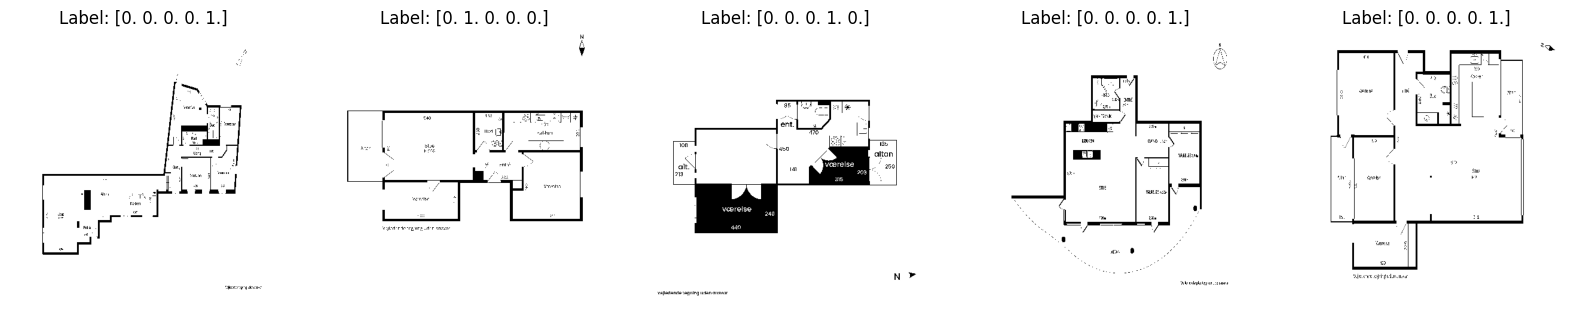

In [5]:
target_width = 448
target_height = 448

resize: bool = True
gray_scale: bool = False
threshhold: bool = True

train_images_RGB = preprocess_images(train_df, "image_floorplan", target_width, target_height, resize = resize, gray_scale = gray_scale, threshhold = threshhold)
validation_images_RGB = preprocess_images(valid_df, "image_floorplan", target_width, target_height, resize = resize, gray_scale = gray_scale, threshhold = threshhold)
test_images_RGB = preprocess_images(test_df, "image_floorplan", target_width, target_height, resize = resize, gray_scale = gray_scale, threshhold = threshhold)

print(f"Train set length:      {len(train_images_RGB)}")
print(f"Validation set length: {len(validation_images_RGB)}")
print(f"Test set length:       {len(test_images_RGB)}")

num_labels = 5

train_labels = prices_to_n_labels(houses_df['price'], train_df['price'], num_labels)
valid_labels = prices_to_n_labels(houses_df['price'], valid_df['price'], num_labels)
test_labels = prices_to_n_labels(houses_df['price'], test_df['price'], num_labels)

#Plot the first 5 images and their labels
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(train_images_RGB[i])
    ax[i].set_title(f"Label: {(train_labels[i])}")
    ax[i].axis('off')
plt.show()

# Pre-trained ViT

## Model Fitting

/home/besplago/.pyenv/versions/penv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2024-03-14 10:31:40.543669: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 10:31:40.564312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA s

1 Physical GPUs, 1 Logical GPU


2024-03-14 10:31:40.762436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 10:31:40.762616: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 10:31:40.762635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2022] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-03-14 10:31:40.762693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 10:31:40.762718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               86250240  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Bat  (None, 11)                44        
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 5)                 60  

2024-03-14 10:32:02.311983: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-14 10:32:02.583874: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-14 10:32:03.943908: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-14 10:32:07.057810: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fea04168df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 10:32:07.057850: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-03-14 10:32:07.062487: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710408727.136471   46177 device_compiler.

15/15 [==============================] - 59s 3s/step - loss: 2.0077 - accuracy: 0.2213 - val_loss: 1.6873 - val_accuracy: 0.2373
Epoch 2/100
15/15 [==============================] - 37s 3s/step - loss: 1.8989 - accuracy: 0.2319 - val_loss: 1.6356 - val_accuracy: 0.2288
Epoch 3/100
15/15 [==============================] - 38s 3s/step - loss: 1.9636 - accuracy: 0.2213 - val_loss: 1.6255 - val_accuracy: 0.2034
Epoch 4/100
15/15 [==============================] - 39s 3s/step - loss: 1.8799 - accuracy: 0.2362 - val_loss: 1.6218 - val_accuracy: 0.2458
Epoch 5/100
15/15 [==============================] - 47s 3s/step - loss: 1.7719 - accuracy: 0.2426 - val_loss: 1.6070 - val_accuracy: 0.2119
Epoch 6/100
15/15 [==============================] - 47s 3s/step - loss: 1.7347 - accuracy: 0.2489 - val_loss: 1.5854 - val_accuracy: 0.2627
Epoch 7/100
15/15 [==============================] - 46s 3s/step - loss: 1.6984 - accuracy: 0.2787 - val_loss: 1.5754 - val_accuracy: 0.2627
Epoch 8/100
15/15 [======

INFO:tensorflow:Assets written to: ./vit-b16_classification_model/assets


INFO:tensorflow:Assets written to: ./vit-b16_classification_model/assets


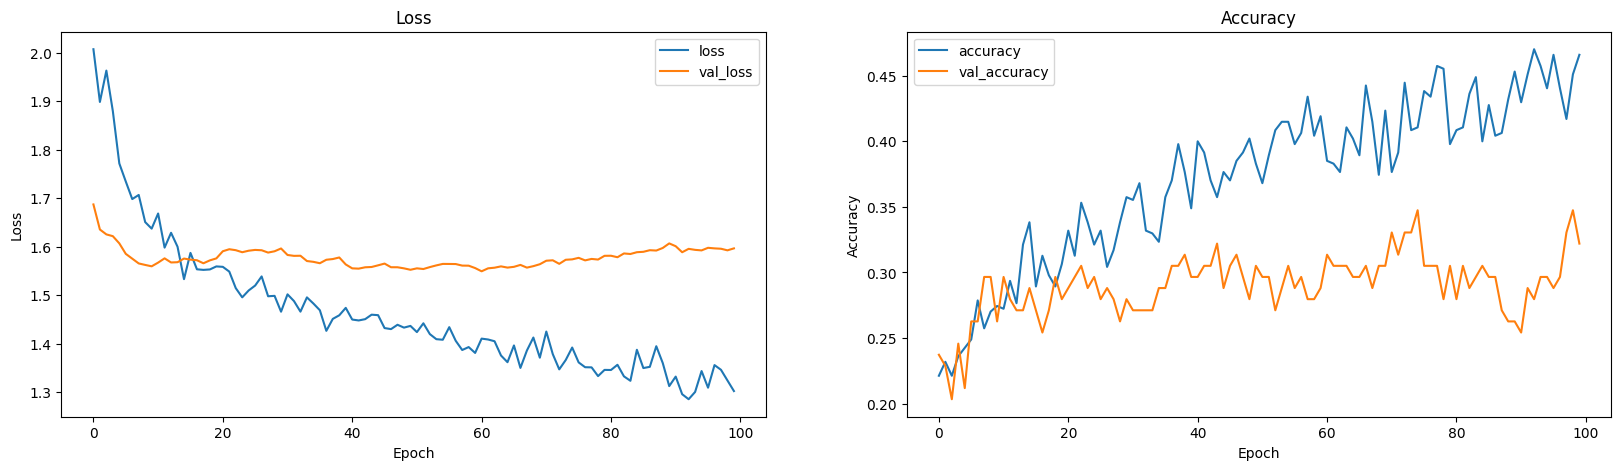

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import gelu
from vit_keras import vit
import tensorflow as tf
from multiprocessing import Process, Queue

def train_model(fine_tune_layers: int = 0):
    """
    Train a model with the vit architecture on the given data.
    
    Args:
        fine_tune_layers (int): Number of layers to fine-tune, counting from the top of the model.
    """
    set_gpu()
    
    # Load pre-trained VGG16 model (excluding top layers)
    base_model = vit.vit_b16(
        weights = 'imagenet21k+imagenet2012',
        image_size = (target_width, target_height),
        activation = 'softmax',
        pretrained = True, 
        include_top = False, 
        pretrained_top = False,
        classes = num_labels
    )

    # Freeze the pre-trained layers
    for layer in base_model.layers[:-fine_tune_layers] if fine_tune_layers > 0 else base_model.layers:
        layer.trainable = False

    # Add new top layers for regression
    model = Sequential([
        base_model,
        Flatten(),
        BatchNormalization(),
        Dense(11, activation = gelu),
        BatchNormalization(),
        Dense(num_labels, activation = 'softmax')
    ], name='vit-b16')

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Train the model with early stopping
    # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # history = model.fit(train_images_RGB, train_labels, validation_data=(validation_images_RGB, valid_labels), epochs=100, callbacks=[early_stopping])
    history = model.fit(train_images_RGB, train_labels, validation_data=(validation_images_RGB, valid_labels), epochs=100)

    model.save("./vit-b16_classification_model")

    # Plot the loss and accuracy
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].plot(history.history['loss'], label='loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[1].plot(history.history['accuracy'], label='accuracy')
    ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.show()

p = Process(target=train_model, args=(0,))
p.start()
p.join()

In [7]:
# vit-b32
# model = Sequential([
#     base_model,
#     Flatten(),
#     BatchNormalization(),
#     Dense(num_labels, activation='softmax')
# ], name='vit-b32')
# learning_rate = 0.0001
# epochs = 100
# results:
#               precision    recall  f1-score   support

#            0       0.55      0.43      0.48        70
#            1       0.57      0.68      0.62        77

#     accuracy                           0.56       147
#    macro avg       0.56      0.55      0.55       147
# weighted avg       0.56      0.56      0.55       147

# model = Sequential([
#     base_model,
#     Flatten(),
#     BatchNormalization(),
#     Dense(11, activation = gelu),
#     BatchNormalization(),
#     Dense(num_labels, activation = 'softmax')
# ], name='vit-b32')
# # learning_rate = 0.0001
# # epochs = 100
# # results:
# #               precision    recall  f1-score   support

# #            0       0.55      0.80      0.65        70
# #            1       0.69      0.40      0.51        77

# #     accuracy                           0.59       147
# #    macro avg       0.62      0.60      0.58       147
# # weighted avg       0.62      0.59      0.58       147

# # learning_rate = 0.0001
# # epochs = 1000
# # results:
# #               precision    recall  f1-score   support

# #            0       0.59      0.47      0.52        70
# #            1       0.59      0.70      0.64        77

# #     accuracy                           0.59       147
# #    macro avg       0.59      0.59      0.58       147
# # weighted avg       0.59      0.59      0.59       147

# # learning_rate = 0.001
# # epochs = 100
# # results:
# #               precision    recall  f1-score   support

# #            0       0.61      0.51      0.56        70
# #            1       0.61      0.70      0.65        77

# #     accuracy                           0.61       147
# #    macro avg       0.61      0.61      0.61       147
# # weighted avg       0.61      0.61      0.61       147

# vit-b16
# model = Sequential([
#     base_model,
#     Flatten(),
#     BatchNormalization(),
#     Dense(11, activation = gelu),
#     BatchNormalization(),
#     Dense(num_labels, activation = 'softmax')
# ], name='vit-b16')
# # learning_rate = 0.001
# # epochs = 1000
# # results:
# #               precision    recall  f1-score   support

# #            0       0.66      0.56      0.60        70
# #            1       0.65      0.74      0.69        77

# #     accuracy                           0.65       147
# #    macro avg       0.65      0.65      0.65       147
# # weighted avg       0.65      0.65      0.65       147

# # labels = 5
# # learning_rate = 0.001
# # epochs = 100
# # results:
# #               precision    recall  f1-score   support

# #            0       0.22      0.23      0.23        26
# #            1       0.30      0.21      0.24        29
# #            2       0.38      0.50      0.43        26
# #            3       0.23      0.28      0.25        29
# #            4       0.55      0.46      0.50        37

# #     accuracy                           0.34       147
# #    macro avg       0.34      0.33      0.33       147
# # weighted avg       0.35      0.34      0.34       147

## Model Evaluation

In [13]:
def evaluate_model(queue: Queue):
    set_gpu()
    
    # Evaluate the model
    loaded_model = tf.keras.models.load_model("./vit-b16_classification_model")
    loaded_model.evaluate(test_images_RGB, test_labels)
    predictions: np.ndarray = loaded_model.predict(test_images_RGB)
    
    queue.put(predictions)

queue = Queue()
p = Process(target=evaluate_model, args=(queue,))
p.start()
p.join()

if queue.empty():
    raise ValueError("Nothing was returned from the process")
predictions = queue.get()
real_labels = np.argmax(test_labels, axis=1)
predicted_labels = np.argmax(predictions, axis=1)

1 Physical GPUs, 1 Logical GPU


2024-03-14 14:11:49.254276: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 14:11:49.293252: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 14:11:49.293374: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 14:11:49.297907: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 14:11:49.298184: I external/local_xla/xla/stream_executor

5/5 [==============================] - 12s 2s/step


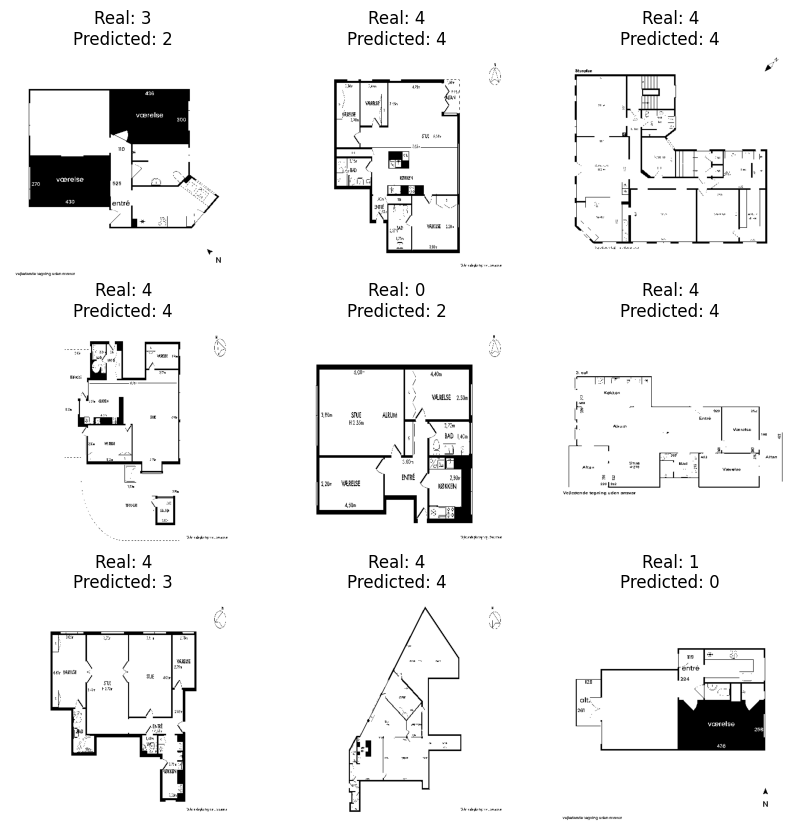

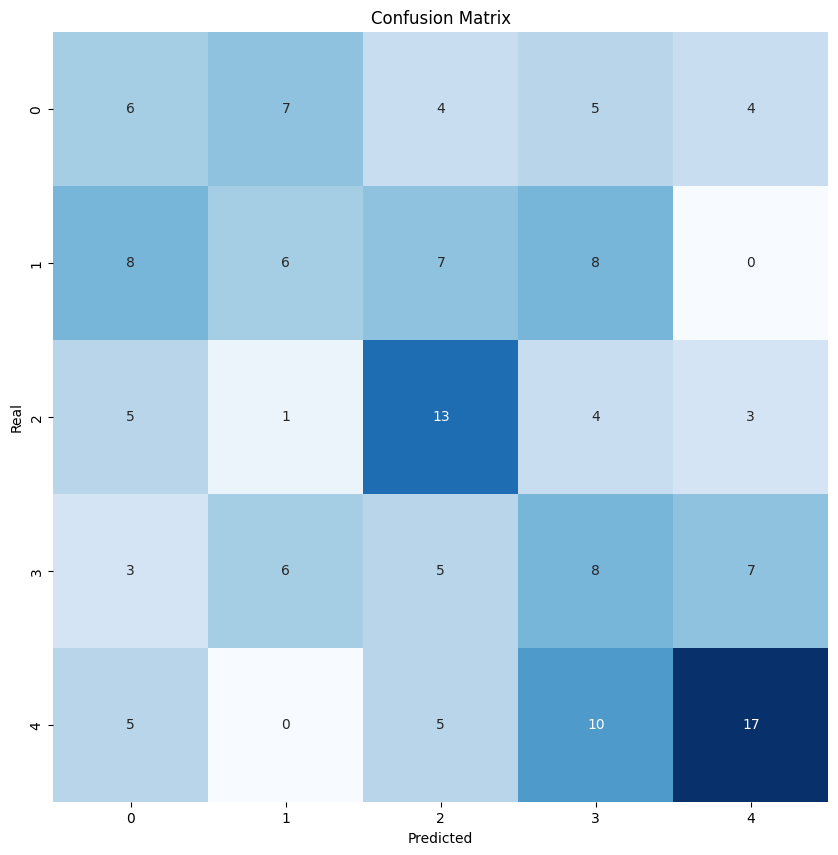

              precision    recall  f1-score   support

           0       0.22      0.23      0.23        26
           1       0.30      0.21      0.24        29
           2       0.38      0.50      0.43        26
           3       0.23      0.28      0.25        29
           4       0.55      0.46      0.50        37

    accuracy                           0.34       147
   macro avg       0.34      0.33      0.33       147
weighted avg       0.35      0.34      0.34       147



In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

# Plot the predictions
plt.figure(figsize=(10, 10))
for i, (image, label, prediction) in enumerate(zip(test_images_RGB[:9], real_labels[:9], predicted_labels[:9])):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Real: {label}\nPredicted: {prediction}")
    plt.axis("off")
plt.show()

# Plot the confusion matrix
confusion = confusion_matrix(real_labels, predicted_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

# Plot the classification report
print(classification_report(real_labels, predicted_labels))

# Plot the ROC curve (only if there are 2 classes)
if num_labels == 2:
    fpr, tpr, thresholds = roc_curve(real_labels, predicted_labels)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [27]:
def evaluate_majority_naive_model():
    """This model simply predicts the majority class"""
    majority_class = np.argmax(np.mean(train_labels, axis=0))
    naive_predictions = np.full((len(test_labels), num_labels), 0)
    naive_predictions[:, majority_class] = 1
    return naive_predictions

def evaluate_random_naive_model():
    """This model simply predicts a random class"""
    naive_predictions = np.zeros((len(test_labels), num_labels))
    for i in range(len(test_labels)):
        naive_predictions[i, np.random.randint(0, num_labels)] = 1
    return naive_predictions

naive_predictions = evaluate_random_naive_model()
naive_predicted_labels = np.argmax(naive_predictions, axis=1)

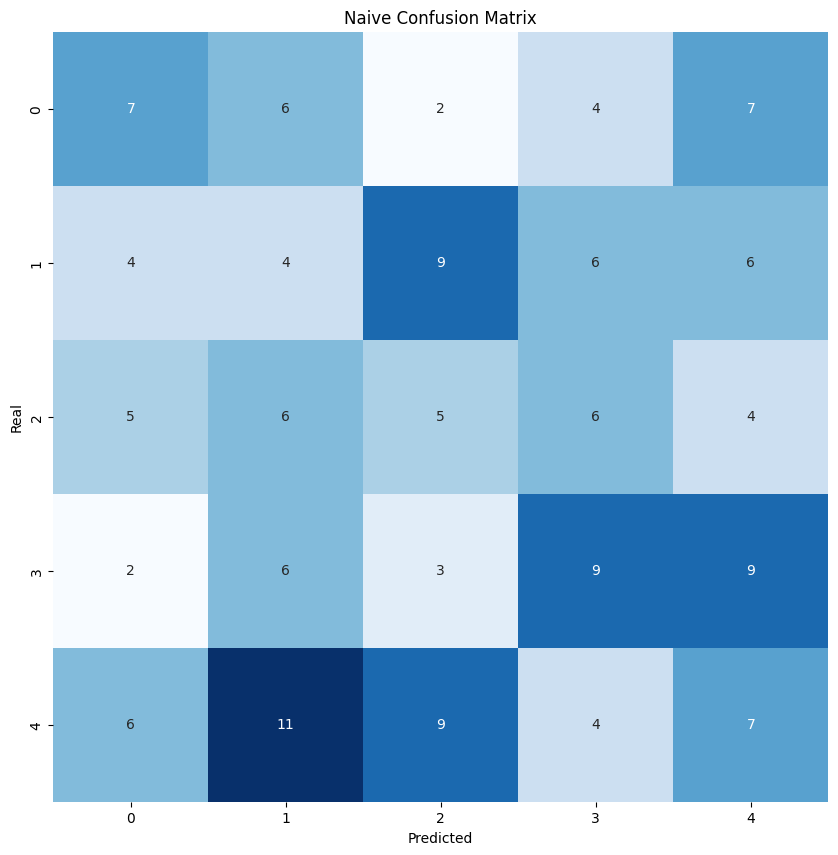

              precision    recall  f1-score   support

           0       0.29      0.27      0.28        26
           1       0.12      0.14      0.13        29
           2       0.18      0.19      0.19        26
           3       0.31      0.31      0.31        29
           4       0.21      0.19      0.20        37

    accuracy                           0.22       147
   macro avg       0.22      0.22      0.22       147
weighted avg       0.22      0.22      0.22       147



In [28]:
# Plot the naive confusion matrix
naive_confusion = confusion_matrix(real_labels, naive_predicted_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(naive_confusion, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Naive Confusion Matrix')
plt.show()

# Plot the naive classification report
print(classification_report(real_labels, naive_predicted_labels))

# Plot the naive ROC curve
if num_labels == 2:
    fpr, tpr, thresholds = roc_curve(real_labels, naive_predicted_labels)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Naive ROC Curve')
    plt.show()